In [24]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

In [25]:
%matplotlib inline

In [26]:
def recolour_image(before, bgr=[1.5, 0.75, 1.25]):
    """
    Recolour greyscale image `before` to new colour `bgr`
    in blue-green-red format
    
    Adapted from: https://stackoverflow.com/a/58142700
    """
    
    before = cv2.cvtColor(before, cv2.COLOR_GRAY2BGR)
    b, g, r = cv2.split(before)

    np.multiply(b, bgr[0], out=b, casting="unsafe")
    np.multiply(g, bgr[1], out=g, casting="unsafe")
    np.multiply(r, bgr[2], out=r, casting="unsafe")

    after = cv2.merge([b, g, r])
    
    return after


def split_images(im):
    """
    Return first and mid-point images from stack
    """
    
    return im[0], im[int(len(im)/2)]


def overlay_images(img1, img2, translation):
    """
    Recolour two greyscale images to red and green,
    flip second image,
    overlay with 50% transparency
    """
    
    M = np.float32([
        [1, 0, translation],
        [0, 1, 0]
    ])
    
    img_0 = recolour_image(img1, bgr=[0, 0, 255])
    img_180 = np.fliplr(recolour_image(img2, bgr=[0, 255, 0]))
    img_180_shift = cv2.warpAffine(img_180, M, (img_180.shape[1], img_180.shape[0]))
    blended = cv2.addWeighted(img_0, 0.5, img_180_shift, 0.5, 0.0)
    blended = cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)
    
    return blended


def subtract_images(img1, img2, translation):
    """
    Translate second image relative to first, and subtract
    """
    
    M = np.float32([
        [1, 0, translation],
        [0, 1, 0]
    ])
    
    img2 = np.fliplr(img2)
    img_180_shift = cv2.warpAffine(img2, M, (img2.shape[1], img2.shape[0]))
    subtracted = cv2.subtract(img1, img_180_shift)
    
    return subtracted


def misalignment(img1, img2, offset):
    """
    Return sum of intensity in central half of difference 
    between two images, as measure of misalignment
    """
    
    x = subtract_images(img1, img2, offset)
    width = np.shape(x)[1]
    intensity = np.concatenate(x[:,width//4:width*3//4]).sum()
    
    return intensity


def align_images(img1, img2):
    """
    Slide two images past each other and find offset which minimises misalignment
    """
    
    width = img1.shape[1]
    frac = 4  # decreasing factor tries larger range of offsets
    offsets = np.arange(-width//frac, width//frac)  # working with integer offsets only
    # misalignments = [misalignment(img1, img2, i) for i in tqdm(offsets)]
    misalignments = [misalignment(img1, img2, i) for i in offsets]
    stack = np.column_stack((offsets, misalignments))
    optimal = stack[np.argmin(stack[:, 1]), 0]
    
    return optimal


def plot_alignment(im):
    """
    Split image, align front and back projections, and plot
    """
    
    img1, img2 = split_images(im)
    optimal = align_images(img1, img2)
    f, axes = plt.subplots(1,2)
    axes[0].imshow(overlay_images(img1, img2, 0).astype(np.uint8))  # rescale to [0,255]
    axes[0].set_title('Original')
    axes[1].imshow(overlay_images(img1, img2, optimal).astype(np.uint8))
    axes[1].set_title(f'Aligned (offset {int(optimal)} px)')
    plt.show()


def top_half(img):
    return img[:, 0:int(img.shape[1]/2), :]


def bottom_half(img):
    return img[:, int(img.shape[1]/2):int(img.shape[1]), :]


def quarters(img):
    height = img.shape[0]
    q1 = img[0:int(height/4), :]
    q2 = img[int(height/4):int(height/2), :]
    q3 = img[int(height/2):int(3*height/4), :]
    q4 = img[int(3*height/4):int(height), :]
    return q1, q2, q3, q4


def quarters2(img):
    height = img.shape[1]
    q1 = img[:, 0:int(height/4), :]
    q2 = img[:, int(height/4):int(height/2), :]
    q3 = img[:, int(height/2):int(3*height/4), :]
    q4 = img[:, int(3*height/4):int(height), :]
    return q1, q2, q3, q4

Note: appearance of plots is significantly improved by using images resized using XnView, rather than ImageJ. (However, doesn't seem to affect functionality.)

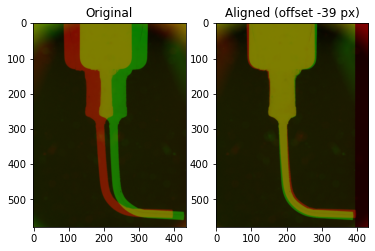

In [27]:
needle = io.imread('../../data_store/2022-11-25 needle alignment_result.tif')
plot_alignment(needle)

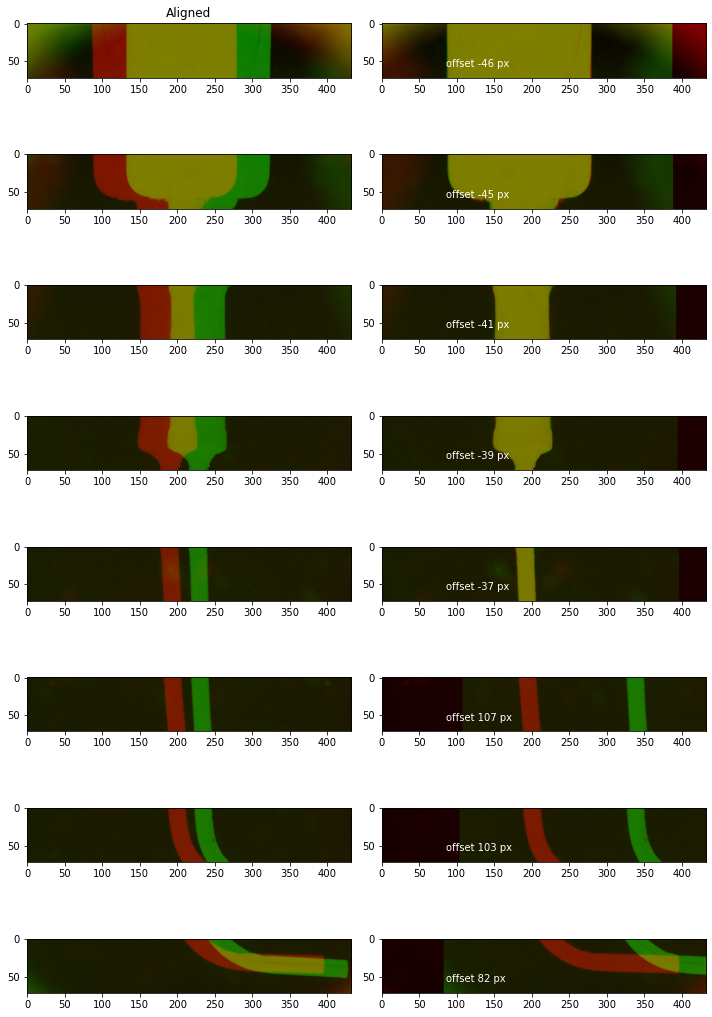

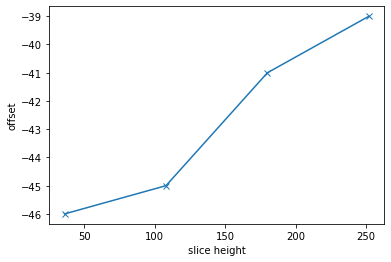

In [28]:
def plot_alignment_tilt(img, number, thresh=None):
    """
    Split image into `number` sections, align each separately,
    get list of offsets, plot, fit, extract tilt angle
    """

    img_sections = np.array_split(img, number, axis=1)
    spacing = img_sections[0].shape[1]//2
    heights = np.arange(spacing, img.shape[1], spacing*2)
    offsets = []

    f, axes = plt.subplots(number, 2, figsize=(10, 15))

    for i in range(len(img_sections)):
        im = img_sections[i]
        img1, img2 = split_images(im)
        optimal = align_images(img1, img2)
        axes[i][0].imshow(overlay_images(img1, img2, 0).astype(np.uint8))  # rescale to [0,255]
        axes[i][1].imshow(overlay_images(img1, img2, optimal).astype(np.uint8))
        axes[i][1].text(0.2, 0.2, f'offset {int(optimal)} px', color='white', transform = axes[i][1].transAxes)
        offsets.append(optimal)

    axes[0][0].set_title('Original')
    axes[0][0].set_title('Aligned')

    plt.tight_layout()
    plt.show()

    if thresh is not None:
        plt.plot(heights[:thresh], offsets[:thresh], 'x-')
    else:
        plt.plot(heights, offsets, 'x-')
    plt.xlabel('slice height')
    plt.ylabel('offset')
    plt.show()

plot_alignment_tilt(needle, 8, 4)
plt.show()